# Finding Heavy Traffic Indicators on I-94

In this project, we're going to analyze a dataset about westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94)

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. 

In [1]:
import pandas as pd
i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
print(i_94.head())
print(i_94.tail())
i_94.info()

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

The dataset contains 48204 rows and 9 columns, which have no null values. Each row describe traffic and weather data per hour from  `2012-10-02 09:00:00` to `2018-09-30 23:00:00`.

The [dataset documention](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) meations that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west). This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

## Analyzing Traffic Volume

We're going to start our analysis by examining the distribution of the `traffic_volume` column.

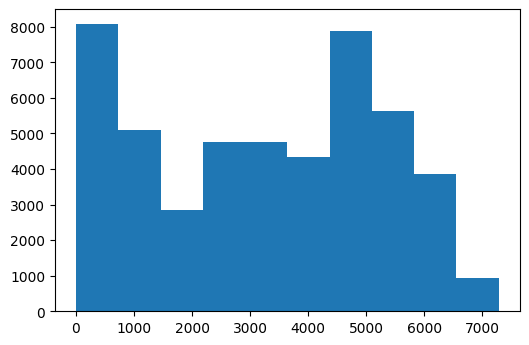

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(i_94['traffic_volume'])
plt.show()

In [3]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Between 2012-10-02 09:00:00 and 2018-09-30 23:00:00, the hourly traffic volume varied from 0 to 7,280 cars, with an average of 3,260 cars.

About 25% of the time, there were 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction.

About 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data.

## Traffic Volume: Day vs. Night

We'll start by diving the dataset into 2 parts:
- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

In [4]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])

day = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
night = i_94.copy()[(i_94['date_time'].dt.hour >= 19) | (i_94['date_time'].dt.hour < 7)]

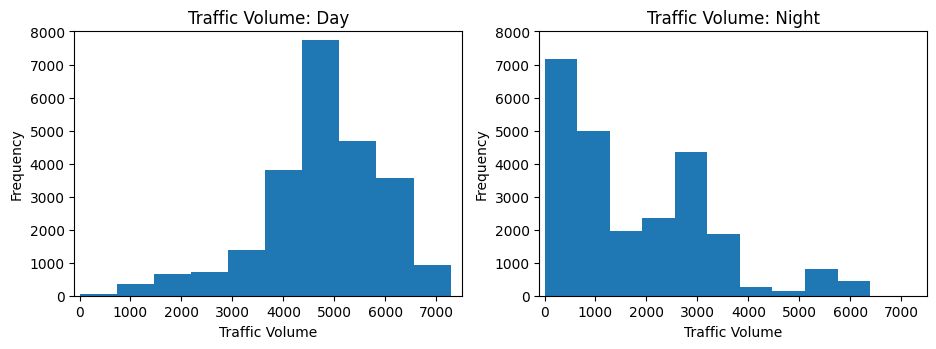

In [5]:
# Plot histograms if `traffic_volume` for both day and night
plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.show()

In [6]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [7]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The histogram that shows the distribution of traffic volume during the day is left skewed. This means that most of the traffic volume values are high — there are 4,252 or more cars passing the station each hour 75% of the time (because 25% of values are less than 4,252).

The histogram displaying the nighttime data is right skewed. This means that most of the traffic volume values are low — 75% of the time, the number of cars that passed the station each hour was less than 2,819.

Although there are still measurements of over 5,000 cars per hour, the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we'll only focus on the daytime data moving forward.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:
- Month
- Day of the week
- Time of day

In [8]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

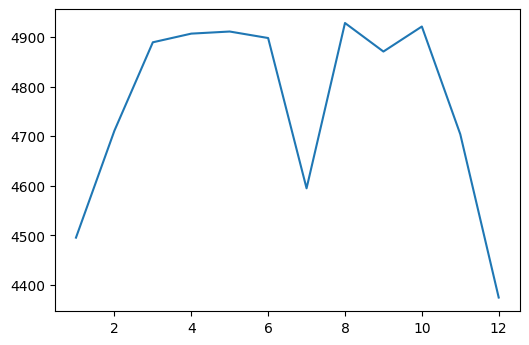

In [9]:
plt.plot(by_month['traffic_volume'])
plt.show()

The traffic looks less heavy during cold months (November–February) and more intense during warm months (March–October), but there is a significant drop in July. Is there anything special about July? Is traffic significantly less heavy in July each year?

In [10]:
day['year'] = day['date_time'].dt.year
july = day[day['month'] == 7]
july_each_year = july.groupby('year').mean()
july_each_year['traffic_volume']

year
2013    4914.354054
2014    4871.598240
2015    4613.146226
2016    3924.923645
2017    4734.120301
2018    4586.899543
Name: traffic_volume, dtype: float64

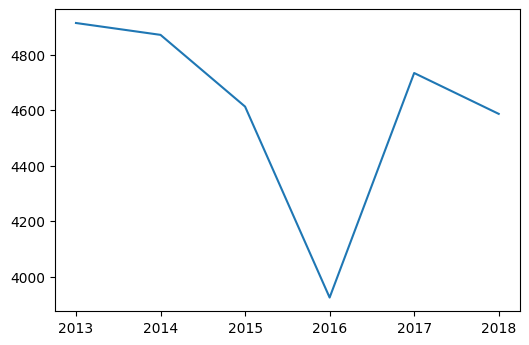

In [11]:
plt.plot(july_each_year['traffic_volume'])
plt.show()

Generally, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. The reason for that decrease may be construction.

Conclusion, we can say that warm months show heavier traffic volume than cold months. In warm months, we continue to analyze traffic volume by day of week.

In [12]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

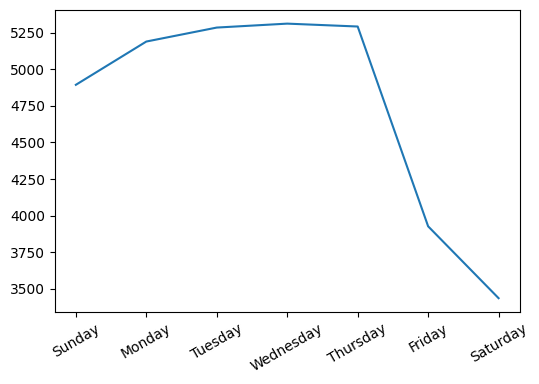

In [13]:
plt.plot(by_dayofweek['traffic_volume'])
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6],
          labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
          rotation = 30)
plt.show()

We found that the traffic volume is significantly heavier on business days compared to the weekends.

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

In [14]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


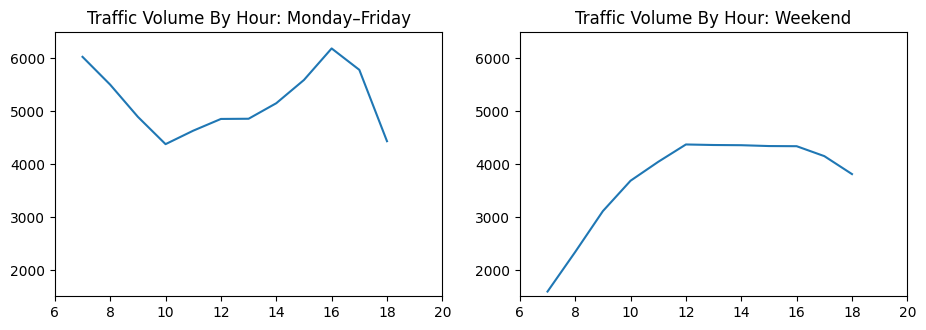

In [15]:
plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
plt.plot(by_hour_business['traffic_volume'])
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Weekend')

plt.show()

So far, we've focused on finding time indicators for heavy traffic, and we reached the following conclusions:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

## Weather Indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

A few of these columns are numerical so let's start by looking up their correlation values with `traffic_volume`.

In [16]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation with a value of just +0.13. The other relevant columns (`rain_1h`, `snow_1h`, `clouds_all`) don't show any strong correlation with traffic_value.

Let's generate a scatter plot to visualize the correlation between temp and `traffic_volume`.

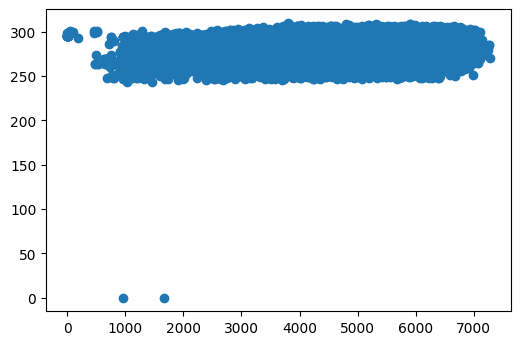

In [17]:
plt.scatter(day['traffic_volume'], day['temp'])
plt.show()

We can see that `temp` is not a reliable indicator of heavy traffic. 

We'll look next at the categorical weather-related columns: `weather_main` and `weather_description`.

## Weather Types

We're going to calculate the average traffic volume associated with each unique value in these two columns.

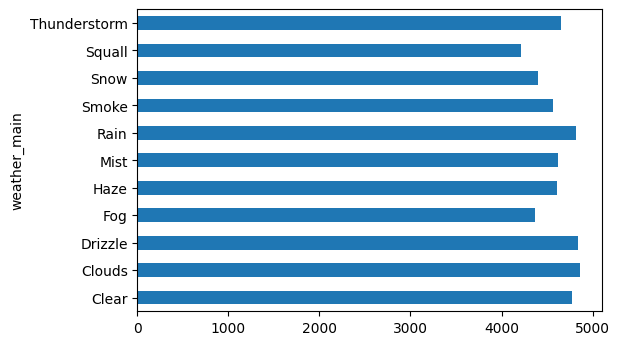

In [18]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

There is no weather type where traffic volume's exceeding 5000 cars. Let's move on to `weather description` to find out the heavy traffic indicator.

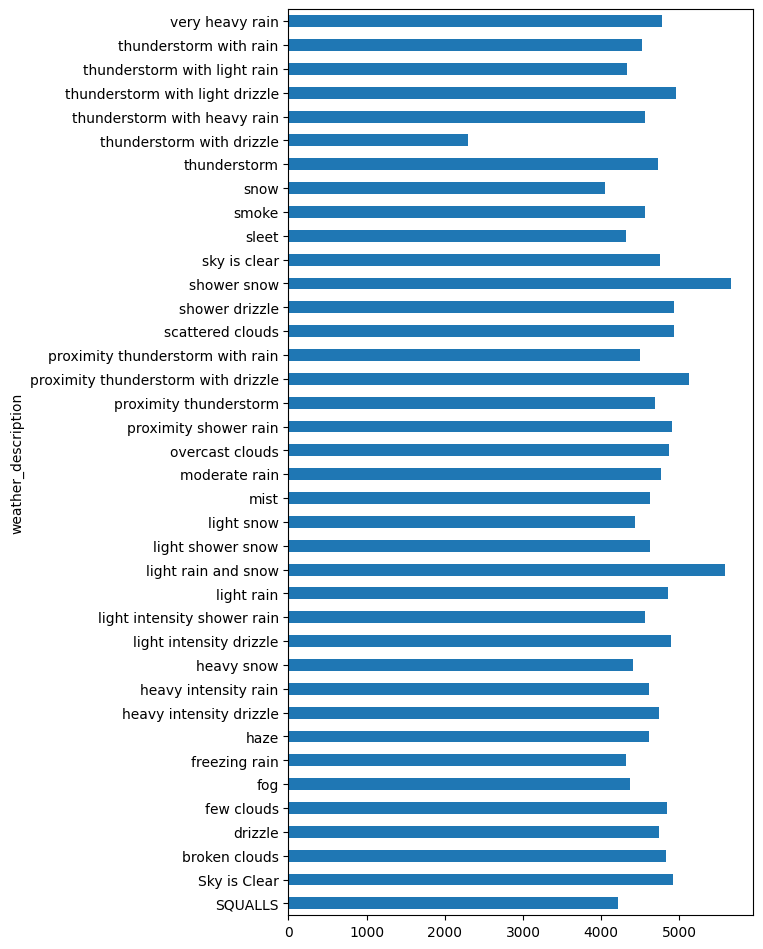

In [19]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize = (6,12))
plt.show()

From the horizontal bar graph, we can find that there are 3 weather types made traffic volume exceeding 5000 cars:
- shower snow
- proximity thunderstorm with dizzle
- light rain and snow

## Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:
- Time indicators
    - The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
    - The traffic is usually heavier on business days compared to the weekends.
    - On business days, the rush hours are around 7 and 16.
- Weather indicators
    - Shower snow
    - Light rain and snow
    - Proximity thunderstorm with drizzle